# Optimal Portfolio
This notebook construct 3 different optimal portfolios. The maximum sharpe-ratio portfolio (*simple risk adjusted return*), the maximum calmar-ratio portfolio (*maximum drawdown adjusted return*) and the minimum variance portfolio.

\begin{align}
    \text{Sharpe Ratio}&=\frac{R_{p}-R_{f}}{\sigma_{p}}\\
    \text{Calmar Ratio}&=\frac{R_{p}-R_{f}}{\text{Maximum Drawdown}}
\end{align}
where $R_{p}$ denotes the portfolio's annualized return, $R_{f}$ denotes the risk-free interest rate, $\sigma_{p}$ denotes the standard deviation ($\approx$*risk*) of the portfolio and maximum drawdown is measured as the pct.-change from trough to peak, i.e. peak-value minus trough-value divided by peak-value.




In [1]:
############## Loading relevant packages ##############
import numpy as np
import pandas as pd
import datetime as dt
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# local module
import pftools
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

## Loading and cleaning data
In this notebook, data can be fetched using the downloaded CSV-files or using the yahoo database.

In [2]:
# pick which tickers to use in the analysis.
# Make sure names are compatible with yahoo database or file-name
tickers = ['SXR8', 'XACTC25', 'XDJP', 'LCUA' ,'SXRP', 'SXRL', 'XJSE']

# getting data from a local csv-file
df, rdf, cdf = pftools.df_generator(tickers,'csv','C:/Users/olufk/OneDrive/Documents/GitHub/PortfolioDesign/PortfolioDesign/OptimalPF/Data_Investing_com/')

Will eventually output description of each ticker in df


In [3]:
# pick which tickers to use in the analysis.
# Make sure names are compatible with yahoo database or file-name
tickers = ['fortum.he', 'danske.co', 'saf.pa', 'wm']

# enter time period of interest
start = dt.datetime(2014, 6, 30)
end = dt.datetime(2019, 6, 30)

# getting data from yahoo database
df, rdf, cdf = pftools.df_generator(tickers,'yahoo')

No starttime selected, has therefore chosen default closest to (5 years before today) 2016-07-01
No endtime selected, has therefore chosen default closest to (today) 2021-06-30
Will eventually output description of each ticker in df


## Describing each tickers
Now that data is loaded, it's time to get an idea of the characteristics of the tickers

C:\Users\olufk\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\olufk\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\olufk\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\olufk\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


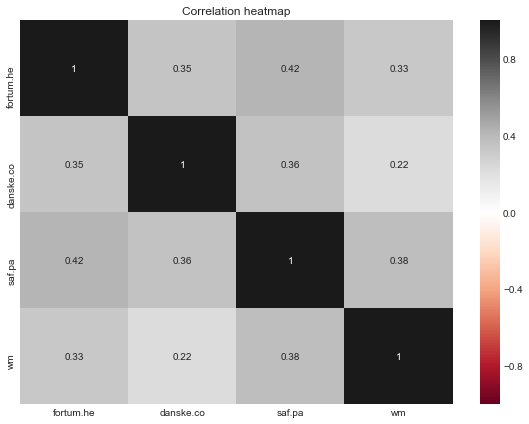

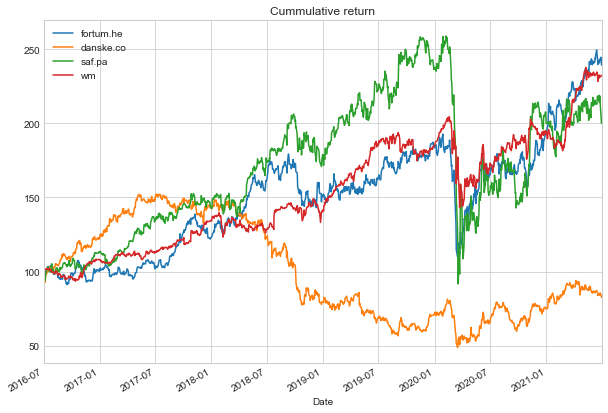

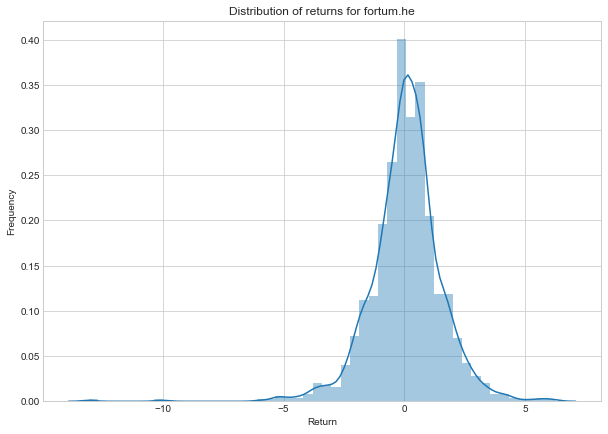

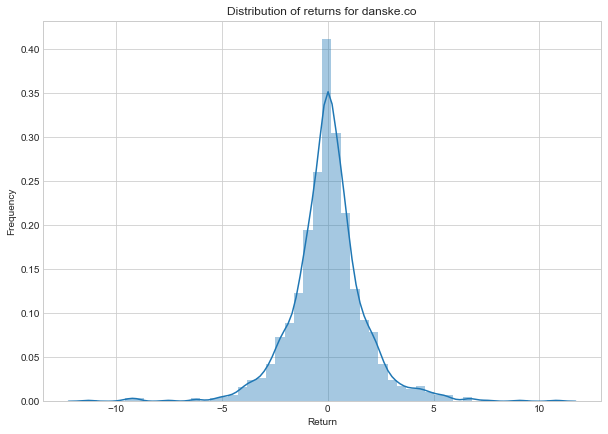

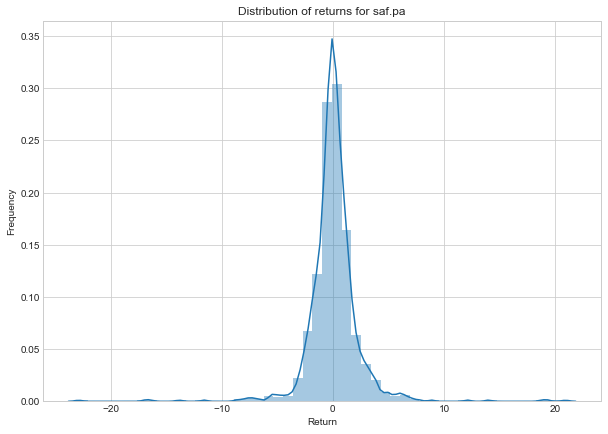

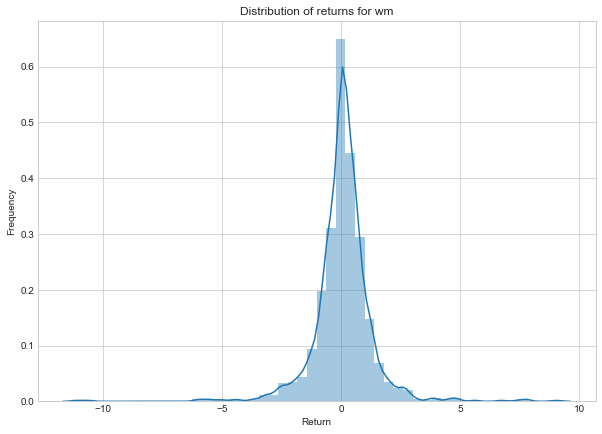

,Ticker,annualized_return,volatility,sharpe_ratio,calmar_ratio
0,fortum.he,12.81,23.68,0.54,0.98
1,danske.co,-2.61,28.66,-0.09,-0.23
2,saf.pa,10.04,36.97,0.27,0.44
3,wm,12.35,20.15,0.61,1.11


In [4]:
pftools.desc_ticks(df,rdf,cdf)

In [15]:
h = 2
print('loss'+'periods')

lossperiods


In [8]:
kkkkkkkkkkkk

100

In [12]:
print(f'Estimating ticker as a ARCH(1,1) model resulted in:')
print(f'Omega^hat                       --> {3.55555555:.3f}')
print(f'alpha^hat                       --> {3.66666666:.3f}')
print(f'Resultes in a log-likelihood of --> {-1450:.3f}')

Estimating ticker as a ARCH(1,1) model resulted in:
Omega^hat                       --> 3.556
alpha^hat                       --> 3.667
Resultes in a log-likelihood of --> -1450.000
